# MLP
## Simple MLP with meta data for comparison

## 01 Load Data

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv('../02_data/content_agnostic/train_data.csv')
test_data = pd.read_csv('../02_data/content_agnostic/test_data.csv')

In [3]:
print("train_data info")
print(train_data.info())
print("-------------------------------------------------")

print("test_data info")
print(test_data.info())
print("-------------------------------------------------")

train_data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   domain      5915 non-null   object 
 1   virality    5915 non-null   float64
 2   avalanches  5915 non-null   float64
 3   messages    5915 non-null   float64
 4   chats       5915 non-null   float64
 5   year        5915 non-null   float64
 6   pc1         5915 non-null   float64
 7   domain_id   5915 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 369.8+ KB
None
-------------------------------------------------
test_data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1479 entries, 0 to 1478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   domain      1479 non-null   object 
 1   virality    1479 non-null   float64
 2   avalanches  1479 non-null   float64
 3   messages    1479 n

## 02 Preprocessing

In [17]:
train_data['label'] = pd.cut(train_data['pc1'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=[0, 1, 2]).astype(int)
test_data['label'] = pd.cut(test_data['pc1'], bins=[-float('inf'), 0.33, 0.66, float('inf')], labels=[0, 1, 2]).astype(int)

train_data["label"].value_counts(normalize=True) * 100

label
1    44.057481
2    40.422654
0    15.519865
Name: proportion, dtype: float64

In [20]:
features = ["virality", "avalanches", "messages", "chats", "year"]
X = train_data[features].values
y = train_data["label"].values
X_test = test_data[features].values
y_test = test_data["label"].values

# train val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
# dataset class
def tensor_dataset(X, y):
    return torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

In [22]:
train_dataset = tensor_dataset(X_train, y_train)
val_dataset = tensor_dataset(X_val, y_val)
test_dataset = tensor_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 03 Model

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 1, 2], y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [28]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

Epoch 1, Train Loss: 1.0397, Val Loss: 1.0126
Epoch 2, Train Loss: 1.0048, Val Loss: 1.0061
Epoch 3, Train Loss: 0.9987, Val Loss: 0.9994
Epoch 4, Train Loss: 0.9943, Val Loss: 0.9964
Epoch 5, Train Loss: 0.9923, Val Loss: 0.9962
Epoch 6, Train Loss: 0.9901, Val Loss: 0.9940
Epoch 7, Train Loss: 0.9899, Val Loss: 0.9937
Epoch 8, Train Loss: 0.9887, Val Loss: 0.9930
Epoch 9, Train Loss: 0.9874, Val Loss: 0.9926
Epoch 10, Train Loss: 0.9880, Val Loss: 0.9966
Epoch 11, Train Loss: 0.9869, Val Loss: 0.9943
Epoch 12, Train Loss: 0.9862, Val Loss: 0.9882
Epoch 13, Train Loss: 0.9861, Val Loss: 0.9918
Epoch 14, Train Loss: 0.9864, Val Loss: 0.9886
Epoch 15, Train Loss: 0.9861, Val Loss: 0.9925
Epoch 16, Train Loss: 0.9852, Val Loss: 0.9871
Epoch 17, Train Loss: 0.9839, Val Loss: 0.9905
Epoch 18, Train Loss: 0.9832, Val Loss: 0.9916
Epoch 19, Train Loss: 0.9832, Val Loss: 0.9889
Epoch 20, Train Loss: 0.9832, Val Loss: 0.9874


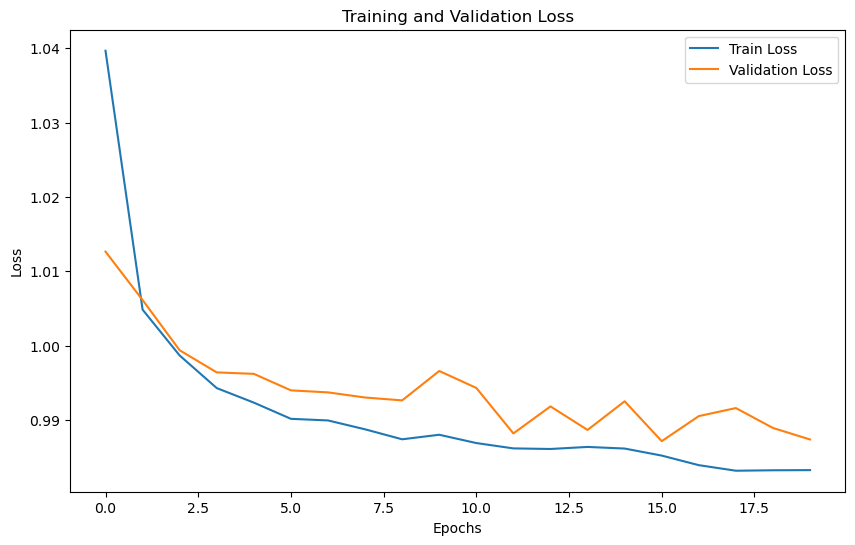

In [29]:
# Model, loss, and optimizer
model = MLP(input_size=5, hidden_size=64, output_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation loss tracking
train_losses = []
val_losses = []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss / len(val_loader):.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 04 Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       179
           1       0.48      0.66      0.56       510
           2       0.53      0.52      0.53       494

    accuracy                           0.50      1183
   macro avg       0.67      0.40      0.36      1183
weighted avg       0.58      0.50      0.46      1183



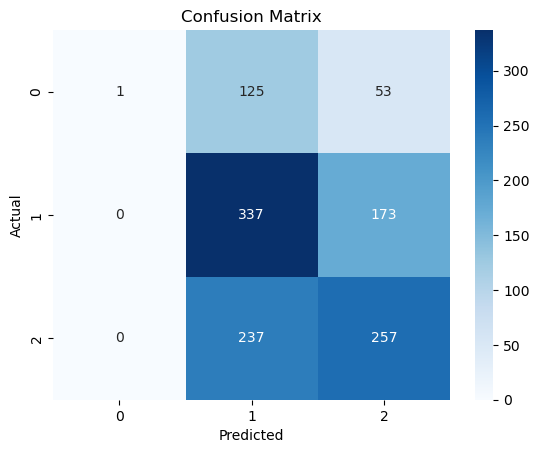

In [30]:
# confusion matrix and classification report
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()